In [34]:
import json
import igraph
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np
import pandas as pd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
with open('san_francisco_censustracts.json') as f:
    geodata = json.load(f)

In [3]:
len(geodata['features'])

2710

In [4]:
coords = np.zeros((len(geodata['features']), 2))
for i in range(len(geodata['features'])):
    coords[i, :] = np.mean(geodata['features'][i]['geometry']['coordinates'][0][0], axis=0)

In [5]:
skip1 = 0
data = {}
for line in open("san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv"):
    csv_row = line.split(',')
    if (skip1 == 1):
        if (csv_row[2] == '12'):
            #print (csv_row[0], csv_row[1], csv_row[3])
            k1 = int (csv_row[0])
            k2 = int(csv_row[1])
            if (k1 <= k2):
                key = (k1, k2)
            else:
                key = (k2, k1)
            if (not (key in data.keys())):
                data[key] = []
            data[key].append(float(csv_row[3]))                
    skip1 = 1

In [6]:
data_tup  = []
for k in data.keys():
    mean_wt = np.mean(data[k])
    data_tup.append((k[0],k[1], mean_wt))

In [7]:
G = igraph.Graph.TupleList(data_tup, directed=False, weights=True)
g_cluster = G.clusters()
g = g_cluster.giant()

In [8]:
vertex_ids = []
for i in range(len(g.vs)):
    vertex_ids.append(int(g.vs[i]['name']))

In [9]:
tri_input = np.zeros((len(coords), 2))

In [10]:
tri_input = coords[[id - 1 for id in vertex_ids], :]

In [11]:
tri_input[0, 0]

-122.05216156249999

In [12]:
del_tri = Delaunay(tri_input)

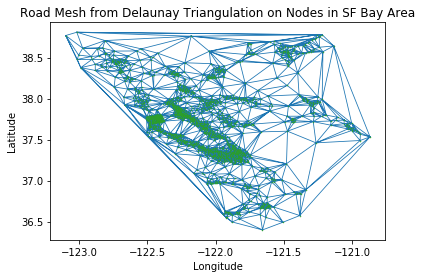

In [13]:
plt.triplot(tri_input[:,0], tri_input[:,1], del_tri.simplices, linewidth=0.8)
plt.plot(tri_input[:,0], tri_input[:,1], '.', markersize=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Mesh from Delaunay Triangulation on Nodes in SF Bay Area')
plt.show()

In [14]:
triangle_ids = del_tri.simplices

In [15]:
triangle_ids

array([[ 693, 1881, 1857],
       [1883, 1807, 1424],
       [1205,  693, 1857],
       ...,
       [ 416, 1078,  668],
       [1078, 1371,  668],
       [1078,  498, 1371]], dtype=int32)

In [16]:
triangle_vert = np.zeros((len(triangle_ids), 3))

In [17]:
for i in range(len(triangle_ids)):
    for j in range(3):
        triangle_vert[i, j] = vertex_ids[triangle_ids[i, j]]

In [18]:
triangle_edges = []
for i in range(len(triangle_vert)):
    triangle_edges.append([triangle_vert[i, 0], triangle_vert[i, 1]])
    triangle_edges.append([triangle_vert[i, 1], triangle_vert[i, 2]])
    triangle_edges.append([triangle_vert[i, 2], triangle_vert[i, 0]])

In [19]:
unique_edges = set()
for i in range(len(triangle_edges)):
    v1 = triangle_edges[i][0]
    v2 = triangle_edges[i][1]
    if(v1 < v2):
        unique_edges.add((v1, v2))
    else:
        unique_edges.add((v2, v1))

In [20]:
len(unique_edges)

5680

In [21]:
my_data = pd.read_csv('san_francisco-censustracts-2017-4-All-MonthlyAggregate_final.csv')

In [22]:
my_data_12 = my_data[my_data['month'] == 12]

In [23]:
len(my_data_12)

555265

In [24]:
my_data_12.head()

,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,1982,73,12,350.59,230.08,311.46,1.56
1,2213,1523,12,872.92,383.89,803.50,1.49
2,438,433,12,2262.35,919.08,2144.34,1.35
3,448,333,12,1337.10,431.10,1277.05,1.35
6,2231,315,12,805.52,309.16,764.44,1.35


In [25]:
my_data_12['min_id'] = my_data_12[['sourceid', 'dstid']].min(axis = 1)

C:\Users\rupa\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
my_data_12['max_id'] = my_data_12[['sourceid', 'dstid']].max(axis = 1)

C:\Users\rupa\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
my_data_12.head()

,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,min_id,max_id
0,1982,73,12,350.59,230.08,311.46,1.56,73,1982
1,2213,1523,12,872.92,383.89,803.50,1.49,1523,2213
2,438,433,12,2262.35,919.08,2144.34,1.35,433,438
3,448,333,12,1337.10,431.10,1277.05,1.35,333,448
6,2231,315,12,805.52,309.16,764.44,1.35,315,2231


In [28]:
ue_l = list(unique_edges)

In [29]:
src = [x[0] for x in ue_l]

In [30]:
dst = [x[1] for x in ue_l]

In [31]:
len(my_data_12[my_data_12.min_id.isin(src) & my_data_12.max_id.isin(dst)])

509377

In [32]:
my_data_12['isedge'] = 0

C:\Users\rupa\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [33]:
my_data_12.iloc[0, 9]

0

In [35]:
for i in tqdm(range(len(my_data_12))):
    x = (my_data_12.iloc[i, 7], my_data_12.iloc[i, 8])
    if x in unique_edges:
        my_data_12.iloc[i, 9] = 1

  0%|                                                                                       | 0/555265 [00:00<?, ?it/s]C:\Users\rupa\Anaconda2\envs\py36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
100%|█████████████████████████████████████████████████████████████████████████| 555265/555265 [20:49<00:00, 444.25it/s]


In [41]:
my_data_time.to_csv('my_data_time.csv', index = False)

In [36]:
my_data_time = my_data_12[my_data_12['isedge'] == 1]

In [37]:
len(my_data_time)

10196

In [38]:
temp = list(my_data_time['sourceid'])
temp2 = list(my_data_time['dstid'])
temp3 = list(set(temp) & set(temp2))

In [39]:
def calc_dist(coor1, coor2):
    return np.sqrt(np.sum(np.square((coor1 - coor2) * 69)))

In [40]:
my_data_time['dist'] = 0
for i in tqdm(range(len(my_data_time))):
    my_data_time.iloc[i, 10] = calc_dist(coords[my_data_time.iloc[i, 0] - 1], coords[my_data_time.iloc[i, 1] - 1])

C:\Users\rupa\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
100%|████████████████████████████████████████████████████████████████████████████| 10196/10196 [17:03<00:00,  9.96it/s]


In [42]:
n = len(unique_edges)
e1 = list(unique_edges)
for i in range(n):
    e1.append(e1[i][::-1])

In [43]:
edges = []
for i in tqdm(range(len(my_data_time))):
    edges.append(list(my_data_time.iloc[i, 0:2]))
    
#find edge with no time
edgeNotime = []
#e1 = list(unique_edges)
for i in tqdm(range(len(unique_edges))):
    if e1[i] in edges:
        continue
    else:
        edgeNotime.append(e1[i])


100%|████████████████████████████████████████████████████████████████████████████| 5680/5680 [00:01<00:00, 4567.06it/s]


In [44]:
my_data_time.to_csv('timeDist.csv', index = False)

In [90]:
with open('sID_dID_time_only.txt', 'w') as f:
    for i in tqdm(range(len(my_data_time))):
        f.write(str(my_data_time.iloc[i,0]) + ' ' + str(my_data_time.iloc[i,1]) +' ' + str(my_data_time.iloc[i, 3]) + '\n')
f.close()

100%|█████████████████████████████████████████████████████████████████████████| 10196/10196 [00:00<00:00, 16508.20it/s]


In [46]:
my_data_time.head()

,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,min_id,max_id,isedge,dist
61,76,834,12,230.97,267.23,139.19,3.05,76,834,1,3.434195
326,1595,606,12,154.49,132.43,122.56,2.02,606,1595,1,0.668909
329,1712,36,12,270.42,263.66,233.56,1.51,36,1712,1,2.677542
772,2643,78,12,154.45,93.97,133.20,1.77,78,2643,1,0.468900
959,2049,1224,12,279.80,261.05,193.56,2.57,1224,2049,1,4.767432


In [91]:
with open('edge_no_time.txt', 'w') as f:
    for i in range(len(edgeNotime)):
        f.write(str(edgeNotime[i][0]) + ' ' + str(edgeNotime[i][1]) + '\n' )
f.close()

In [92]:
with open('sID_dID_time_dist.txt', 'w') as f:
    for i in range(len(my_data_time)):
        f.write(str(my_data_time.iloc[i,0]) + ' ' + str(my_data_time.iloc[i,1]) + ' ' + str(my_data_time.iloc[i, 3])+ ' ' + str(my_data_time.iloc[i, 10]) + '\n')
f.close()

In [49]:
############### Calculate flow ##################

In [50]:
src=[]
dest=[]
time=[]
dis=[]
with open('edge_time_dist.txt', 'r') as f:
    for line in f:
        arr = line.split('\t')
        src.append(int(arr[0]))
        dest.append(int(arr[1]))
        time.append(float(arr[2]))
        dis.append(float(arr[3]))
f.close()
d = {'A.sourceid': src, 'B.dstid': dest, 'C.time': time, 'distance': dis}
q12 = pd.DataFrame(data=d)

In [51]:
q12.head(2)

,A.sourceid,B.dstid,C.time,distance
0,76,834,230.97,3.434195
1,1595,606,154.49,0.668909


In [52]:
def flow(time, dist):
    v = (dist/time)*3600
    return (v * 2)/ (0.003 + v/1800) 

In [53]:
cars = []
src=[]
dest=[]
for i in range(len(q12)):
    cars.append(flow(q12.iloc[i, 2], q12.iloc[i, 3]))
    src.append(q12.iloc[i, 0])
    dest.append(q12.iloc[i, 1])
d = {'A.sourceid': src, 'B.dstid': dest, 'C.Flow': cars}
q12_flow = pd.DataFrame(data=d)

In [54]:
############################ Q13 ##################################

In [55]:
with open('q13_flow.txt', 'w') as f:
    for i in range(len(q12)):
        f.write(str(q12_flow.iloc[i, 0])+ ' ' +str(q12_flow.iloc[i, 1])+ ' ' +str(q12_flow.iloc[i, 2])+ '\n' )
f.close()

In [56]:
def p2id(geodata, p1, p2):
    point = Point(p1, p2)
    for i in range(len(geodata['features'])):
        points = np.asarray(geodata['features'][i]['geometry']['coordinates'][0][0])
        polygon = Polygon(points)
        if polygon.contains(point) == 1:
            break
    return (int(geodata['features'][i]['properties']['MOVEMENT_ID']))

In [57]:
p2id(geodata, -122.1887333, 37.4269353)#Stanford ID = 2607

2607

In [58]:
p2id(geodata, -122.0748253, 36.9731906)#UCSC ID = 1968

1968

100%|███████████████████████████████████████████████████████████████████████████| 10551/10551 [01:16<00:00, 137.28it/s]


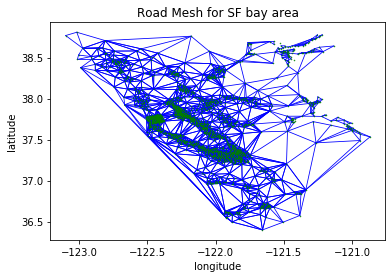

In [59]:
for i in tqdm(range(len(q12))):
    src_id = q12['A.sourceid'][i]
    dst_id = q12['B.dstid'][i]
    x = [coords[src_id - 1][0], coords[dst_id - 1] [0]]
    y = [coords[src_id - 1][1], coords[dst_id - 1] [1]]
    plt.plot(x, y, color='blue', linewidth=0.8)
plt.plot(tri_input[:,0], tri_input[:,1], '.', color = 'green', markersize=1)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Road Mesh for SF bay area')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████| 10551/10551 [01:16<00:00, 138.66it/s]


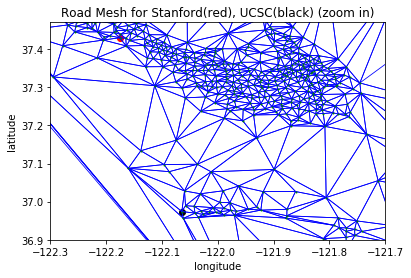

In [62]:
plt.plot(-122.17598222,   37.42968589, 'o', color='red')
plt.plot(-122.06456181,   36.97416881, 'o', color='black')
for i in tqdm(range(len(q12))):
    src_id = int(q12.iloc[i, 0])
    dst_id = int(q12.iloc[i, 1])
    x = [coords[src_id - 1][0], coords[dst_id - 1][0]]
    y = [coords[src_id - 1][1], coords[dst_id - 1][1]]
    plt.plot(x, y, color='blue', linewidth=0.8)

plt.plot(tri_input[:,0], tri_input[:,1], '.', color = 'green', markersize=2)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Road Mesh for Stanford(red), UCSC(black) (zoom in)')
plt.xlim(-122.30, -121.7)
plt.ylim(36.90, 37.47)
plt.show()

100%|███████████████████████████████████████████████████████████████████████████| 10551/10551 [01:15<00:00, 140.67it/s]


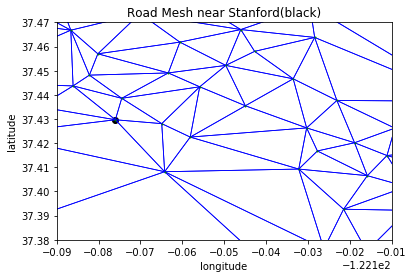

In [64]:
#plot3
plt.plot(-122.17598222,   37.42968589, 'o', color = 'black')
for i in tqdm(range(len(q12))):
    src_id = int(q12.iloc[i, 0])
    dst_id = int(q12.iloc[i, 1])
    x = [coords[src_id - 1][0], coords[dst_id - 1][0]]
    y = [coords[src_id - 1][1], coords[dst_id - 1][1]]
    plt.plot(x, y, color='blue', linewidth=0.8)
    
plt.plot(tri_input[:,0], tri_input[:,1], '.', color = 'green', markersize=2)
plt.xlim(-122.19, -122.11)
plt.ylim(37.38, 37.47)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Road Mesh near Stanford(black)')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████| 10551/10551 [02:25<00:00, 72.51it/s]


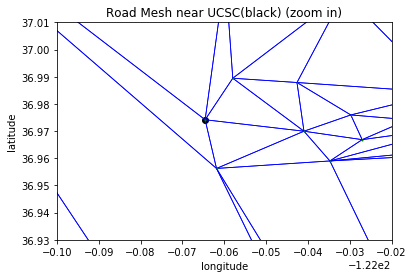

In [132]:
#plot 4
plt.plot(-122.06456181,   36.97416881, 'o', color = 'black')
for i in tqdm(range(len(q12))):
    src_id = int(q12.iloc[i, 0])
    dst_id = int(q12.iloc[i, 1])
    x = [coords[src_id - 1][0], coords[dst_id - 1][0]]
    y = [coords[src_id - 1][1], coords[dst_id - 1][1]]
    plt.plot(x, y, color='blue', linewidth=0.8)
   
plt.plot(tri_input[:,0], tri_input[:,1], '.', color='green', markersize=2)
plt.xlim(-122.10, -122.02)
plt.ylim(36.93, 37.01)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Road Mesh near UCSC(black)')
plt.show()

In [65]:
point = Point(-122.479, 37.83) # 260.11sec, 332.08 sec

In [66]:
point = Point(-122.387, 37.93)#2121 to 1653, 454.32sec, 423.75 sec

In [67]:
#Golden Gate Bridge: [1292, 950]
p2id(geodata, -122.475, 37.806)

1292

In [68]:
p2id(geodata, -122.479, 37.83)

950

In [69]:
#Richmond, San Rafael Bridge: [2121, 1653]
p2id(geodata, -122.501, 37.956)

2121

In [70]:
p2id(geodata, -122.387, 37.93)

1653

In [71]:
#San Mateo Bridge: [2247, 2236]
p2id(geodata, -122.273, 37.563)

2247

In [72]:
p2id(geodata, -122.122, 37.627)

2236

In [73]:
#Dambarton Bridge: [1473, 2686]
p2id(geodata, -122.142, 37.486)

1473

In [74]:
p2id(geodata, -122.067, 37.54)

2686

In [75]:
#San Francisco - Oakland Bay Bridge: [2308, 285]
p2id(geodata, -122.388, 37.788)

2308

In [76]:
p2id(geodata, -122.302, 37.825)

285

In [77]:
calc_dist(np.asarray([-122.388, 37.788]), np.asarray([-122.302, 37.825]))
node1 = [p2id(geodata, -122.475, 37.806), p2id(geodata, -122.479, 37.83)] # 260.11sec, 332.08 sec
node2 = [p2id(geodata, -122.501, 37.956), p2id(geodata, -122.387, 37.93)]# 454.32, 423.75 sec
node3 = [p2id(geodata, -122.273, 37.563), p2id(geodata, -122.122, 37.627)]# 581.54, 575.08
node4 = [p2id(geodata, -122.142, 37.486), p2id(geodata, -122.067, 37.54)]# 529.8, 790.67
node5 = [p2id(geodata, -122.388, 37.788), p2id(geodata, -122.302, 37.825)] # 493.36, 618.5

In [78]:
def findtimeof2ID(q12, node):
    for i in tqdm(range(len(q12))):
        if q12.iloc[i, 0] == node[0]:
            if q12.iloc[i, 1] == node[1]:
                break
    time1 = q12.iloc[i,2]
    for i in range(len(q12)):
        if q12.iloc[i, 0] == node[1]:
            if q12.iloc[i, 1] == node[0]:
                break
    time2 = q12.iloc[i,2]
    return [time1, time2]

In [79]:
findtimeof2ID(q12, node5)

100%|█████████████████████████████████████████████████████████████████████████| 10551/10551 [00:00<00:00, 66766.90it/s]


[974.09, 974.09]

In [80]:
q12.head()

,A.sourceid,B.dstid,C.time,distance
0,76,834,230.97,3.434195
1,1595,606,154.49,0.668909
2,1712,36,270.42,2.677542
3,2643,78,154.45,0.468900
4,2049,1224,279.80,4.767432


In [81]:
time_threshold = 750
i_thrs = []
for i in range(len(q12)):
    if q12.iloc[i,2] < time_threshold:
        i_thrs.append(i)

In [82]:
q14_flow = q12_flow.iloc[i_thrs,:]

with open('q15_flow.txt', 'w') as f:
    for i in range(len(q14_flow)):
        f12.write(str(q14_flow.iloc[i, 0])+ ' ' +str(q14_flow.iloc[i, 1])+ ' ' +str(q14_flow.iloc[i, 2])+ '\n' )
f.close()

In [181]:
q14_flow

,A.sourceid,B.dstid,C.Flow
0,76,834,3270.099551
1,1595,606,2673.723244
2,1712,36,3126.374849
3,2643,78,2409.506197
4,2049,1224,3308.717632
5,456,1498,2226.321691
6,562,87,2634.505445
7,1922,1220,2912.236203
8,1804,252,3025.668501
9,270,2588,2552.335082


100%|█████████████████████████████████████████████████████████████████████████████| 9892/9892 [01:11<00:00, 139.09it/s]


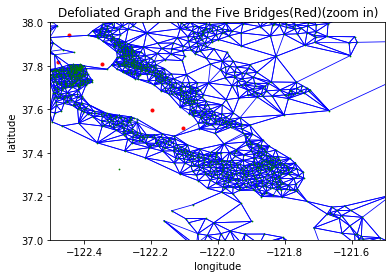

In [83]:
plt.plot((np.asarray([-122.475, 37.806]) + np.asarray([-122.479, 37.83]))[0]/2,  
         (np.asarray([-122.475, 37.806]) + np.asarray([-122.479, 37.83]))[1]/2, 
         'o', color='red', markersize=3)
plt.plot((np.asarray([-122.501, 37.956]) + np.asarray([-122.387, 37.93]))[0]/2, 
         (np.asarray([-122.501, 37.956]) + np.asarray([-122.387, 37.93]))[1]/2, 
         'o', color='red', markersize=3)
plt.plot((np.asarray([-122.273, 37.563]) + np.asarray([-122.122, 37.627]))[0]/2, 
         (np.asarray([-122.273, 37.563]) + np.asarray([-122.122, 37.627]))[1]/2, 
         'o', color='red', markersize=3)
plt.plot((np.asarray([-122.142, 37.486]) + np.asarray([-122.067, 37.54]))[0]/2, 
         (np.asarray([-122.142, 37.486]) + np.asarray([-122.067, 37.54]))[1]/2, 
         'o', color='red', markersize=3)
plt.plot((np.asarray([-122.388, 37.788]) + np.asarray([-122.302, 37.825]))[0]/2, 
         (np.asarray([-122.388, 37.788]) + np.asarray([-122.302, 37.825]))[1]/2, 
         'o', color='red', markersize=3)

for i in tqdm(range(len(q14_flow))):
    src_id = int(q14_flow.iloc[i, 0])
    dst_id = int(q14_flow.iloc[i, 1])
    x = [coords[src_id - 1][0], coords[dst_id - 1][0]]
    y = [coords[src_id - 1][1], coords[dst_id - 1][1]]
    plt.plot(x, y, color='blue', linewidth=0.8)
    
plt.plot(tri_input[:,0], tri_input[:,1], '.', color = 'green', markersize=1.5)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Defoliated Graph and the Five Bridges(Red)(zoom in)')
plt.xlim(-122.50, -121.5)
plt.ylim(37.00, 38.00)
plt.show()

In [84]:
#fix q12_flow
time_threshold = 750
i_thrs = []
for i in range(q12.shape[0]):
    if q12.iloc[i,2] < time_threshold:
        i_thrs.append(i)

In [85]:
q14_flow = q12_flow.iloc[i_thrs,:]

100%|█████████████████████████████████████████████████████████████████████████████| 9892/9892 [01:11<00:00, 138.96it/s]


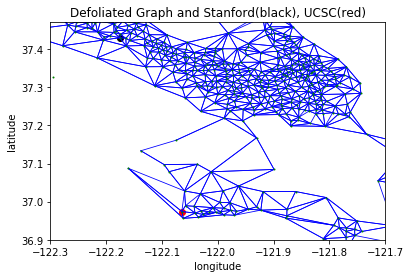

In [87]:
#plot1
plt.plot(-122.17598222,   37.42968589, 'o', color = 'black')
plt.plot(-122.06456181,   36.97416881, 'o', color = 'red')
for i in tqdm(range(len(q14_flow))):
    src_id = int(q14_flow.iloc[i, 0])
    dst_id = int(q14_flow.iloc[i, 1])
    x = [coords[src_id - 1][0], coords[dst_id - 1][0]]
    y = [coords[src_id - 1][1], coords[dst_id - 1][1]]
    plt.plot(x, y, color='blue', linewidth=0.8)
    
plt.plot(tri_input[:,0], tri_input[:,1], '.', color = 'green', markersize=2)
plt.xlim(-122.30, -121.7)
plt.ylim(36.90, 37.47)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Defoliated Graph and Stanford(black), UCSC(red)')
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 9892/9892 [01:10<00:00, 139.77it/s]


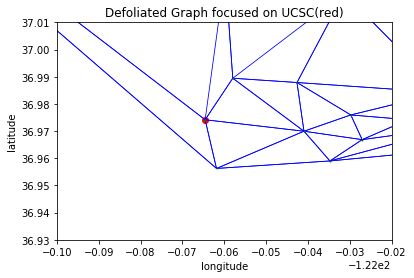

In [88]:
#plot 2
plt.plot(-122.06456181,   36.97416881, 'o', color = 'red')
for i in tqdm(range(len(q14_flow))):
    src_id = int(q14_flow.iloc[i, 0])
    dst_id = int(q14_flow.iloc[i, 1])
    x = [coords[src_id - 1][0], coords[dst_id - 1][0]]
    y = [coords[src_id - 1][1], coords[dst_id - 1][1]]
    plt.plot(x, y, color='blue', linewidth=0.8)
    
plt.plot(tri_input[:,0], tri_input[:,1], '.', color = 'green', markersize=2)
plt.xlim(-122.10, -122.02)
plt.ylim(36.93, 37.01)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Defoliated Graph focused on UCSC(red)')
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 9892/9892 [01:17<00:00, 127.66it/s]


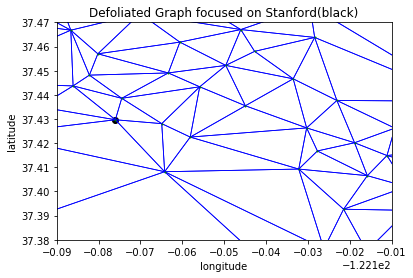

In [89]:
#plot3
plt.plot(-122.17598222,   37.42968589, 'o', color = 'black')
for i in tqdm(range(len(q14_flow))):
    src_id = int(q14_flow.iloc[i, 0])
    dst_id = int(q14_flow.iloc[i, 1])
    x = [coords[src_id - 1][0], coords[dst_id - 1][0]]
    y = [coords[src_id - 1][1], coords[dst_id - 1][1]]
    plt.plot(x, y, color='blue', linewidth=0.8)
    
plt.plot(tri_input[:,0], tri_input[:,1], '.', color = 'green', markersize=2)
plt.xlim(-122.19, -122.11)
plt.ylim(37.38, 37.47)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Defoliated Graph focused on Stanford(black)')
plt.show()